# Disneyland Reviews Analysis

- Reviews and Ratings of 3 Disneyland branches - California, Hong Kong and Paris.
- The dataset analysed includes 42,000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import re

# libraries to apply NLP to the Reviews
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from scipy.stats import ttest_ind
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models



In [4]:
df = pd.read_csv('DisneylandReviews-2.csv', encoding='latin1')
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


In [5]:
df.shape

(42656, 6)

In [6]:
df['Year_Month'].unique()

array(['2019-4', '2019-5', '2019-3', '2018-9', '2019-1', '2018-11',
       '2018-12', '2018-6', '2019-2', '2018-10', '2018-8', '2018-5',
       '2018-4', '2018-7', '2018-3', '2018-2', 'missing', '2018-1',
       '2017-12', '2017-11', '2017-6', '2017-10', '2017-9', '2017-8',
       '2017-7', '2017-5', '2017-4', '2017-3', '2017-2', '2017-1',
       '2016-12', '2016-11', '2016-10', '2016-9', '2016-8', '2016-7',
       '2016-6', '2016-5', '2016-4', '2016-3', '2016-2', '2016-1',
       '2015-12', '2015-11', '2015-10', '2015-9', '2015-8', '2015-7',
       '2015-6', '2015-5', '2015-4', '2015-3', '2015-2', '2015-1',
       '2014-12', '2014-11', '2014-10', '2014-9', '2014-8', '2014-7',
       '2014-6', '2014-5', '2014-4', '2014-3', '2014-2', '2014-1',
       '2013-12', '2013-11', '2013-10', '2013-9', '2013-8', '2013-7',
       '2013-6', '2013-5', '2013-4', '2013-3', '2013-2', '2013-1',
       '2012-12', '2012-11', '2012-10', '2012-9', '2012-8', '2012-7',
       '2012-6', '2012-5', '2012-4', '20

##### Na coluna Year-Month vamos excluir todos os valores escrito 'missing'. 
Como são apenas 2613 numeros, não vai impactar a quantidade valores da tabela pois representa apenas 6% do todo, e exatamente 6% de cada uma das categorias. 

In [7]:
df = df.loc[df['Year_Month'] != 'missing']

In [8]:
df.dtypes

Review_ID             int64
Rating                int64
Year_Month           object
Reviewer_Location    object
Review_Text          object
Branch               object
dtype: object

#### Vamos transformar os valores de Year-Month para datetime no format mes/ano

In [9]:
df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y-%m')
df.dtypes

/var/folders/ct/vm1dw8k165xfctx2hdsx3bc00000gn/T/ipykernel_2703/794941153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y-%m')


Review_ID                     int64
Rating                        int64
Year_Month           datetime64[ns]
Reviewer_Location            object
Review_Text                  object
Branch                       object
dtype: object

#### Não vamos precisar da coluna Review_ID. Vamos excluir.

In [10]:
df = df.drop('Review_ID', axis=1)

#### Average Rating per Branch

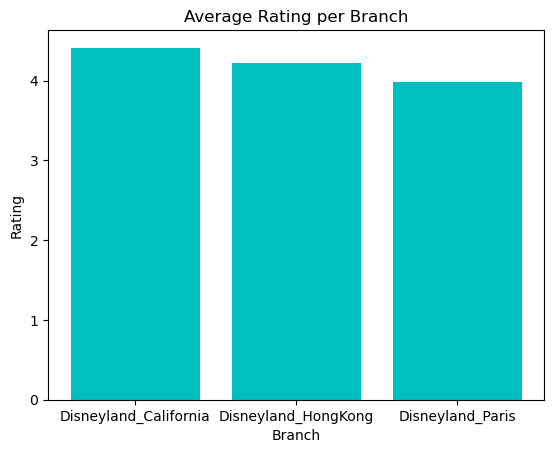

<Figure size 1500x500 with 0 Axes>

In [11]:
rate_per_branch = df.groupby('Branch')['Rating'].mean()
plt.bar(rate_per_branch.index, rate_per_branch, color='c')
plt.xlabel('Branch')
plt.ylabel('Rating')
plt.title('Average Rating per Branch')
plt.figure(figsize=(15,5))
plt.show()

#### Rate frequency 

Text(0.5, 1.0, 'Frequency of Ratings')

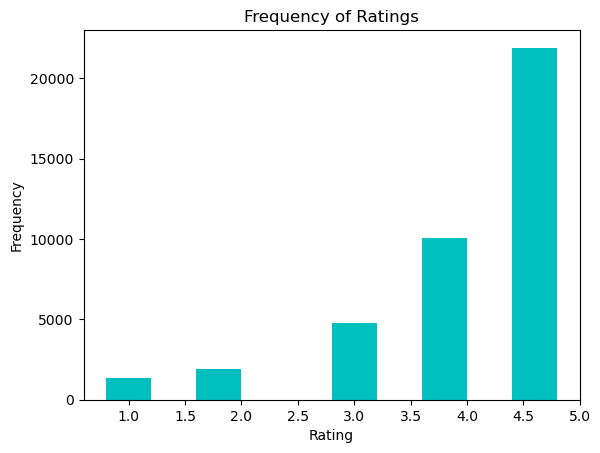

In [12]:
plt.hist(df['Rating'], color='c', density=False, align='left')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Ratings')


#### Avg Rating per Month

<function matplotlib.pyplot.show(close=None, block=None)>

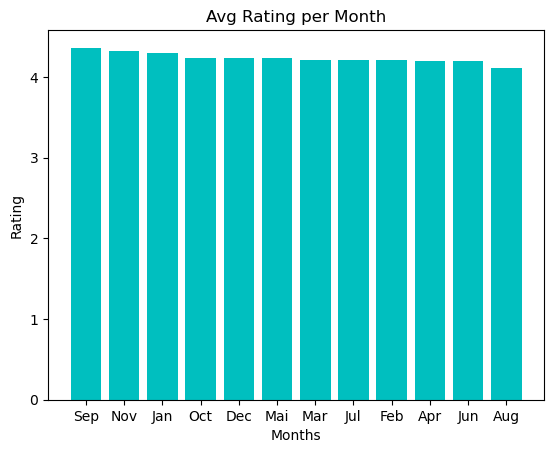

In [13]:
rating_month = df.groupby(df['Year_Month'].dt.month)['Rating'].mean().reset_index().sort_values(by='Rating', ascending=False)
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
rating_month['Year_Month'] = rating_month['Year_Month'].map(month_names)
rating_month = rating_month.rename(columns={'Year_Month': 'Month'})
plt.bar(rating_month['Month'], rating_month['Rating'], color='c')
plt.xlabel('Months')
plt.ylabel('Rating')
plt.title('Avg Rating per Month')
plt.show

#### Number of reviews per month

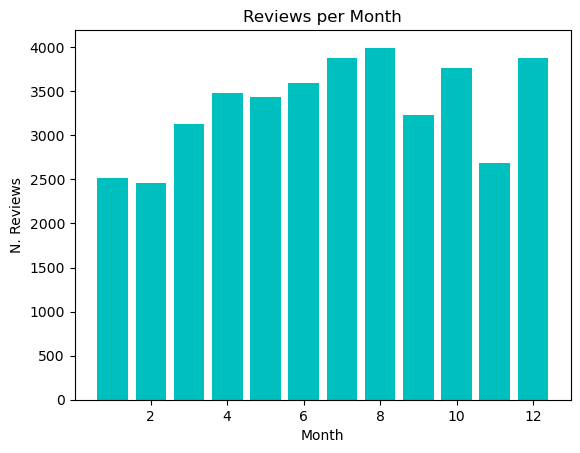

In [14]:
reviews_per_month = df.groupby(df['Year_Month'].dt.month)['Rating'].size().reset_index().rename(columns={'Rating': 'N. of Reviews'}).sort_values(by='N. of Reviews', ascending=False)
reviews_per_month

plt.bar(reviews_per_month['Year_Month'], reviews_per_month['N. of Reviews'], color='c')
plt.xlabel('Month')
plt.ylabel('N. Reviews')
plt.title('Reviews per Month')
plt.show()

# NLP

-- Now we will start reviewing the Reviews_Text from visitors.

-- We will use the library NLTK to classify each review into positive, negative, or neutral.

-- In order to accurately do so, we will pre-process the texto and let it ready to apply NLP techniques and go on with our review.

First we will:
1) Join all the reviews into a single big string (let all in lower case too).
2) Apply Tokenization to separate by words which will guarantee a correct pre-processing.
3) Apply Stop Words to remove all the arcticles and words that don't represent sentiment and opinion (do, the, an, a, etc..)
4) Apply Lemmatization which will take each word and convert to its 'root' word so it will preserve the meaning and it will keep focusing on words in the form that really matter (example, 'delayed' would become 'delay' (so 'delay' is the lemma of 'delayed'). 

After this 4 etaps, we will be able to classify each review into positive, negative, or neutral sentiment, and create a wordcloud for positive reviews and negative reviews.

In [15]:
# defining from which language the stopwords should be considered
stop_words_custom = {'wa', 'u', " 've ", 'pa', 'even' }
stop_words = set(stopwords.words('english')).union(stop_words_custom)

# transforming the module WordNetLemmatizer into a simpler form as 'lemmatizer'
lemmatizer = WordNetLemmatizer()

#create a function to process every value from the columns Review_Text
def preprocess(review):
    tokens = re.findall(r'\b\w+\b', review.lower()) #word_tokenize(review.lower()) # transforming the review into tokens
    lemmas = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2] # applying the lemma in the words that are already tokenized. It will create a list of lemmas.
    processed = ' '.join(lemmas) # to make the list of lemmas back to a single string
    return processed
    
df['Processed Reviews'] = df['Review_Text'].apply(preprocess)

In [16]:
def sentiment(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
df['Sentiment'] = df['Processed Reviews'].apply(sentiment)

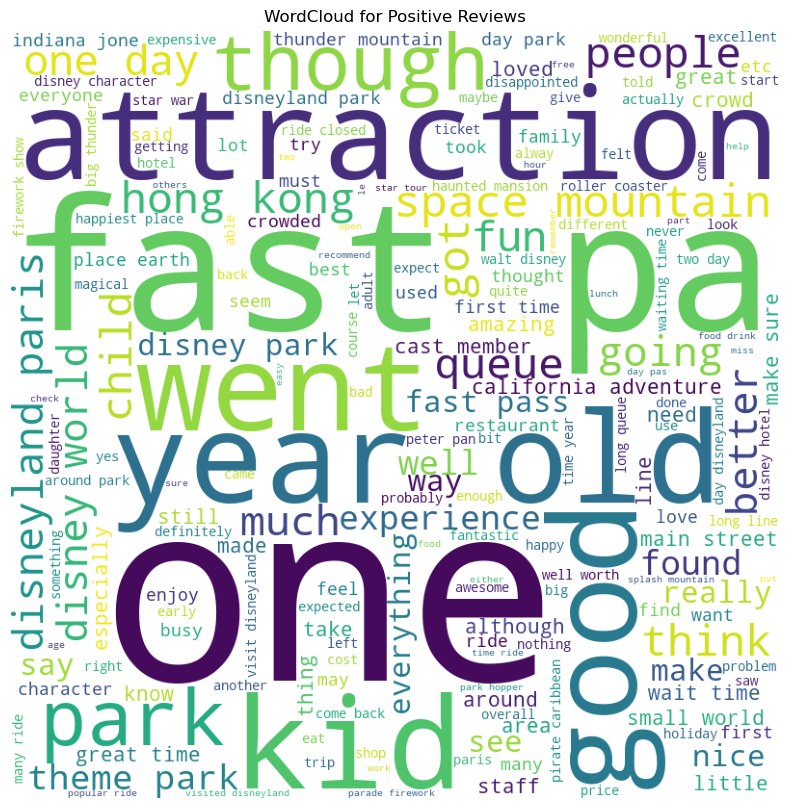

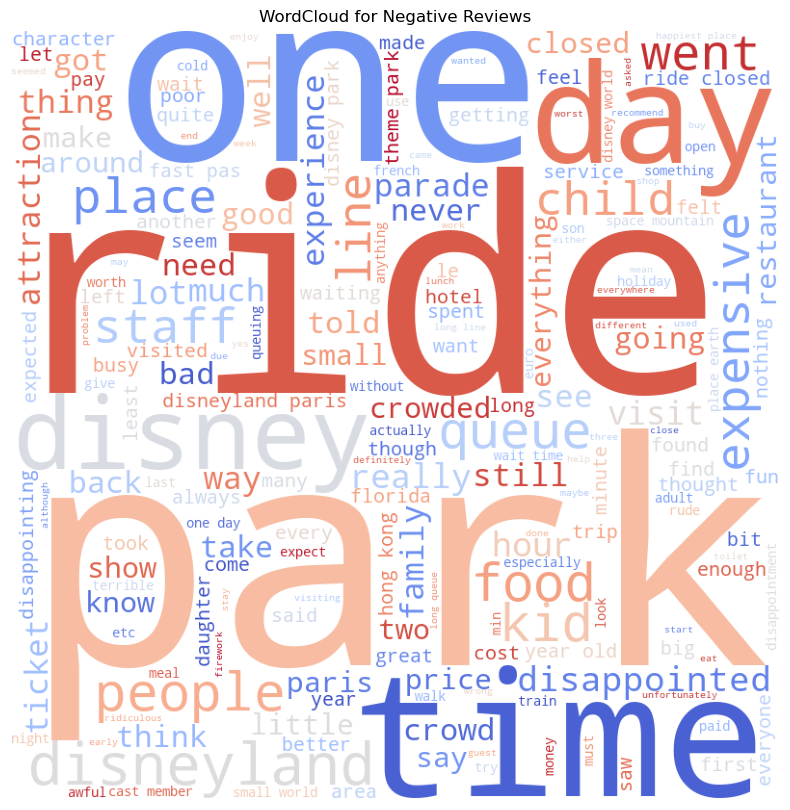

In [17]:
#sentimentdf = df[['Sentiment','Processed Reviews']]
#sentimentdf

positive_reviews = df.loc[df['Sentiment'] == 'Positive', 'Processed Reviews'].tolist()
negative_reviews = df.loc[df['Sentiment'] == 'Negative', 'Processed Reviews'].tolist()

processing_positive = ' '.join(positive_reviews)
processing_negative = ' '.join(negative_reviews)

wordcloud_positive = WordCloud(width=800, height=800, background_color='white', min_font_size=10, colormap='viridis').generate(processing_positive)
wordcloud_negative = WordCloud(width=800, height=800, background_color='white', min_font_size=10, colormap='coolwarm').generate(processing_negative)

plt.figure(figsize=(18,10), facecolor=None)
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.title('WordCloud for Positive Reviews')
plt.show()

plt.figure(figsize=(18,10), facecolor=None)
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.title('WordCloud for Negative Reviews')
plt.show()

In [18]:
newdf = df[['Sentiment','Reviewer_Location']]
us = newdf[newdf['Reviewer_Location'] == 'United States']
total = us['Sentiment'].value_counts()
total

Positive    12249
Negative     1121
Neutral       152
Name: Sentiment, dtype: int64

In [19]:
newdataframe = df.copy()
newdataframe['Review_Length'] = newdataframe['Review_Text'].str.len()
newdataframe

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Processed Reviews,Sentiment,Review_Length
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,ever disneyland anywhere find disneyland hong ...,Positive,329
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,since last time visit disneyland yet time stay...,Positive,970
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,thanks god hot humid visiting park otherwise w...,Positive,938
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,disneyland great compact park unfortunately qu...,Positive,485
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,location city took around hour kowlon kid like...,Positive,163
...,...,...,...,...,...,...,...,...
42113,4,2011-01-01,United Kingdom,Although our pick up was prompt the taxi drive...,Disneyland_Paris,although pick prompt taxi driver wasnt sure ti...,Positive,1574
42114,4,2011-01-01,Germany,Just returned from a 4 days family trip to Dis...,Disneyland_Paris,returned day family trip disneyland two boy ag...,Positive,3593
42115,1,2010-12-01,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Disneyland_Paris,spent dec 2010 disney park lunchtime attractio...,Negative,2537
42116,2,2010-12-01,United Kingdom,Well I was really looking forward to this trip...,Disneyland_Paris,well really looking forward trip christmas per...,Positive,1758


# Hypothesis 1: Negative Reviews are longer

Null Hypothesis (H0): There is no difference in the average review length between positive, negative, and neutral sentiments.

Alternative Hypothesis (H1): The average review length is different between at least two sentiment categories.

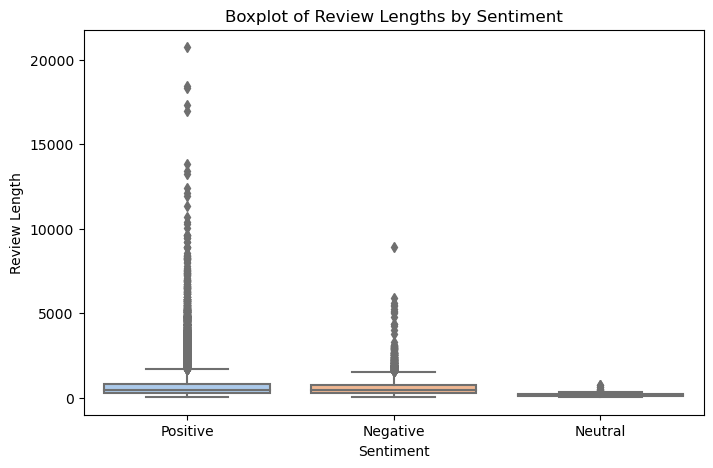

  Sentiment  Review_Length
0  Negative     608.107829
1   Neutral     173.736413
2  Positive     690.614781


In [20]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=newdataframe, x='Sentiment', y='Review_Length', palette='pastel')
plt.title('Boxplot of Review Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

correlation = newdataframe.groupby('Sentiment')['Review_Length'].mean().reset_index()
print(correlation)

In [21]:
positive_lengths = newdataframe[newdataframe['Sentiment'] == 'Positive']['Review_Length']
negative_lengths = newdataframe[newdataframe['Sentiment'] == 'Negative']['Review_Length']

t_statistic, p_value = ttest_ind(positive_lengths, negative_lengths)

alpha = 0.05

# Print the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Compare p-value with alpha
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in the average review length between positive and negative sentiments.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in the average review length between positive and negative sentiments.")

T-statistic: 5.83776496601775
P-value: 5.331672653437778e-09
Reject the null hypothesis.
There is a significant difference in the average review length between positive and negative sentiments.


# Top 3 visiting countries per branch

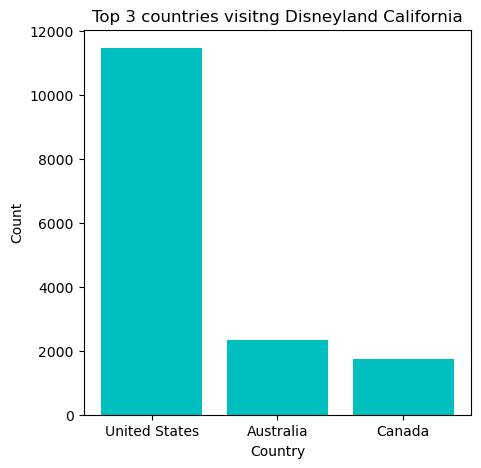

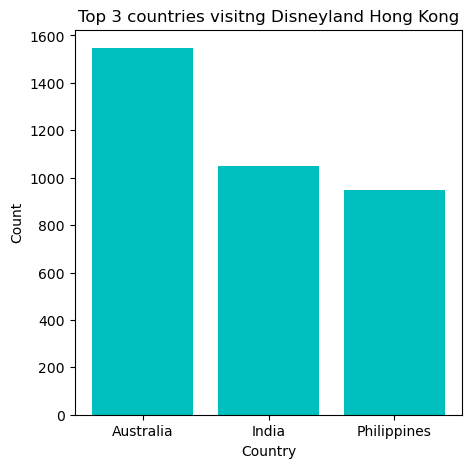

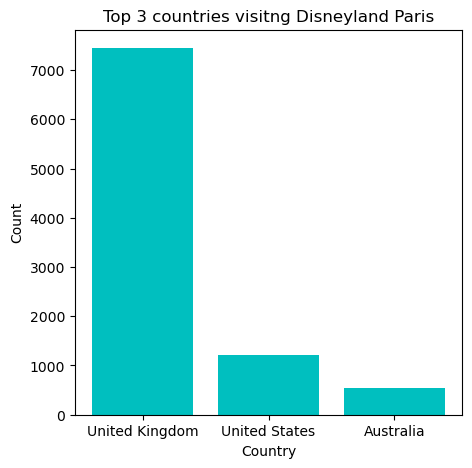

In [22]:
bylocation = df.copy()
bylocation = bylocation[['Rating','Branch','Reviewer_Location','Sentiment']]
countries_calif = bylocation.loc[bylocation['Branch'] == 'Disneyland_California']['Reviewer_Location'].value_counts().head(3).reset_index()
countries_hkong = bylocation.loc[bylocation['Branch'] == 'Disneyland_HongKong']['Reviewer_Location'].value_counts().head(3).reset_index()
countries_paris = bylocation.loc[bylocation['Branch'] == 'Disneyland_Paris']['Reviewer_Location'].value_counts().head(3).reset_index()

countries_calif.columns = ['Country', 'Count']
countries_hkong.columns = ['Country', 'Count']
countries_paris.columns = ['Country', 'Count']

plt.figure(figsize=(5,5))
plt.bar(x = countries_calif['Country'], height = countries_calif['Count'], color='c')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 3 countries visitng Disneyland California')
plt.show()

plt.figure(figsize=(5,5))
plt.bar(x = countries_hkong['Country'], height = countries_hkong['Count'], color='c')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 3 countries visitng Disneyland Hong Kong')
plt.show()

plt.figure(figsize=(5,5))
plt.bar(x = countries_paris['Country'], height = countries_paris['Count'], color='c')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 3 countries visitng Disneyland Paris')
plt.show()



In [33]:
lda_df = df.copy()
lda = lda_df[['Processed Reviews','Sentiment','Branch']]


,Processed Reviews,Sentiment,Branch
0,ever disneyland anywhere find disneyland hong ...,Positive,Disneyland_HongKong
1,since last time visit disneyland yet time stay...,Positive,Disneyland_HongKong
2,thanks god hot humid visiting park otherwise w...,Positive,Disneyland_HongKong
3,disneyland great compact park unfortunately qu...,Positive,Disneyland_HongKong
4,location city took around hour kowlon kid like...,Positive,Disneyland_HongKong
...,...,...,...
42113,although pick prompt taxi driver wasnt sure ti...,Positive,Disneyland_Paris
42114,returned day family trip disneyland two boy ag...,Positive,Disneyland_Paris
42115,spent dec 2010 disney park lunchtime attractio...,Negative,Disneyland_Paris
42116,well really looking forward trip christmas per...,Positive,Disneyland_Paris
